In [1]:
import timeit
from pathlib import Path


import sys
sys.path.append(str(Path.cwd().parent / "classes"))
sys.path.append(str(Path.cwd().parent))

import pandas as pd
from matplotlib import pyplot as plt

from sim_config import SimConfiguration
from simulation import Simulation
from msa import Msa


<Axes: xlabel='factor', ylabel='true'>

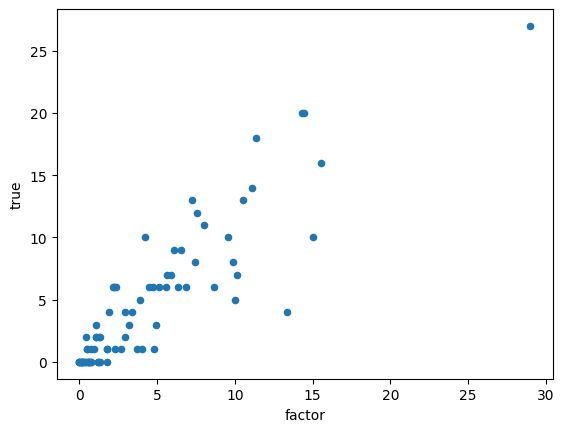

In [23]:
ROOT_SEQUENCE_LENGTH = 1000

TREES_PATH = Path.cwd() / "TRUE_TREES"
time_winners = []
measured_times: list[list[float]] = []



def refresh_sim(tree_file):
    sim_config = SimConfiguration(original_sequence_length=ROOT_SEQUENCE_LENGTH, indel_length_alpha=2.0,
                                indel_truncated_length=50,
                                rate_ins=0.03, rate_del=0.09,
                                deletion_extra_edge_length=5,
                                switch_factor=50,
                                seed=81)
    sim = Simulation(input_tree=str(tree_file), config=sim_config)

    return sim

factor_compare = {"true": [], "factor": []}

sim = refresh_sim("/home/elyawy/temp/evo-sim/benchmark/TRUE_TREES/ZNF385B_true_tree.txt")
for i in sim.sim_nodes[1:]:
    factor_compare["true"].append(len(i.list_of_events))
    factor_compare["factor"].append(i.hybrid_factor)

comparison_df = pd.DataFrame(factor_compare)
comparison_df.plot.scatter(x="factor",y="true")

In [21]:
comparison_df.corr()

,true,factor
true,1.000000,0.946385
factor,0.946385,1.000000


In [18]:
comparison_df["dist"] = (comparison_df.true - comparison_df.factor)**2

In [19]:
comparison_df.loc[comparison_df["dist"].argmax()]

true      17.000000
factor     9.581449
dist      55.034896
Name: 3, dtype: float64

In [22]:
a = -2.0

zipf_sum = sum([x**a for x in range(1,51)])
avg = sum([x*(x**a/zipf_sum) for x in range(1,51)])
avg

2.7685156081393822